<div style="position: relative; text-align: center; padding: 30px;">
  <h1><strong>Clasificador Bayesiano Ingenuo</strong></h1>
  <h3><strong>Walter y Heri</strong></h3>
</div>

**Objetivo**
El objetivo de esta actividad es que cada equipo implemente su propio clasificador bayesiano y lo implemente utilizando la base de datos Heart Disease.

**Instrucciones**

1. Diseña una clase que implemente un clasificador bayesiano ingenuo (sin usar funciones de sklearn):
   - La clase debe construirse recibiendo un único parámetro que indica si la distribución de variables continuas se estimará usando la normal o KDE.

2. Método `.fit()`:
   - Debe recibir como parámetros de entrada:
     - Los datos de entrenamiento `X`, `y`. Donde `X` guarda los valores de las variables y `y` la clase a la que pertenece cada dato.
     - Un diccionario que indique las variables (índices o nombres de columnas) que son "continuas", "enteras" y "categóricas".
   - El método `.fit()` debe calcular:
     - Las probabilidades a priori de cada clase en `Y`, es decir, `P(Y=y_i)`.
     - Las funciones de masa o densidad de probabilidad condicionales `p(X_j = x | Y = y_i)`, para cada `j=1,...,L` y `y_i` para `i=1,...,M`, donde `L` es la dimensión de los datos y `M` el número de clases.
     - Para las variables categóricas debe usar la distribución Bernoulli (o en general distribución categórica).
     - Para las variables enteras calcular la media y estimar el pdf de una distribución Poisson.
     - Para las variables continuas calcular la media y la varianza de los datos para estimar el pdf de la normal, o estimar el KDE, de acuerdo con el parámetro de la clase.

3. Método `.predict()`:
   - Debe recibir un vector `X_pred` que debe tener el mismo número de columnas que `X`.
   - Calcular el clasificador bayesiano ingenuo `\PI_{j=1}^L p(X_j=x_j | Y=y_i)P(Y=y_i)` para cada clase `i=1,...,M` y devolver el valor de `y_i` que lo maximiza.

4. Prueba tu clasificador usando los datos de Heart Disease:
   - Divide tus datos de entrenamiento y prueba de forma aleatoria. Usa proporciones 70-30 u 80-20.
   - Elige entre 5 y 7 variables para tu clasificación. Debe incluir por lo menos una categórica, una entera y una continua.
   - Calcula la exactitud global de tu clasificación.

**Recomendaciones**

- Para la normal se sugiere utilizar el método `.pdf()` de la función `scipy.stats.norm`.
- Para la poisson se sugiere utilizar el método `.pdf()` de la función `scipy.stats.poisson`.
- Para el KDE se sugiere utilizar el método `.evaluate()` de la función `scipy.stats.gaussian_kde`.

Recuerda documentar adecuadamente tu código. Particularmente es importante que el método `fit` y `predict` estén documentados.

In [190]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli, multinomial, gaussian_kde, shapiro, kstest, poisson
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report

In [191]:
cleavland = pd.read_csv('05-heart+disease/processed.cleveland.data', header=None, encoding='ISO-8859-1')
hungary = pd.read_csv('05-heart+disease/processed.hungarian.data', header=None, encoding='ISO-8859-1')
switzerland = pd.read_csv('05-heart+disease/processed.switzerland.data', header=None, encoding='ISO-8859-1')
va = pd.read_csv('05-heart+disease/processed.va.data', header=None, encoding='ISO-8859-1')

In [192]:
attributes = ["Age", "Sex", "Chest Pain Type", "Resting Blood Pressure", "Cholesterol", "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Induced Angina", "ST Depression", "Slope", "Number of Major Vessels", "Thal", "Diagnosis of Heart Disease"]

cleavland.columns = attributes
hungary.columns = attributes
switzerland.columns = attributes
va.columns = attributes

In [193]:
df = pd.concat([cleavland, hungary, switzerland, va], ignore_index=True)

In [194]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

## **Clase**

In [195]:
class bayes_naive:

    def __init__(self, normalokde):

        if normalokde == 'normal':
            self.esnormal = True
            print('Se usará la distribución normal')
        else:
            self.esnormal = False
            print('Se usará la distribución KDE')

    def fit(self, train, test, dictionary_of_distributions):

        self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes, dict = fit(train, test, dictionary_of_distributions, esnormal=self.esnormal)

        self.distributions = dictionary_of_distributions
        self.train = train
        self.test = test

        return self.pxjIwi, self.pwi, self.Iwi, self.classes, self.attributes, dict


    def predict(self, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):
        return predict(self.classes, self.pwi, self.Iwi, self.distributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)
    

    def probar_el_clasificador(self):

        testdf = probar_el_clasificador(self.classes, self.train, self.test, self.distributions, self.Iwi, esnormal=self.esnormal)
        
        self.y_pred = testdf['PREDICT PREDICT']
        self.y_true = testdf[self.test.name]
        
        return testdf
    

    def confusion_matrix(self, cmap='Blues', title='Matriz de Confusión', xlabel='Predicciones', ylabel='Verdaderos'):
        return matriz_confusion(self.y_true, self.y_pred, cmap, title, xlabel, ylabel)
    
    
    def reporte_de_clasificacion(self):
        return print(classification_report(self.y_true, self.y_pred))



## **Funciones**

In [196]:
def probability_categorical(attribute, value, Iwi):
    exitoIwi = len(Iwi[Iwi[attribute] == value])    # cantidad de veces que X_i|w_i = x_i
    nIwi = len(Iwi)                                 # n    
    p = exitoIwi/nIwi                               
    return p

In [197]:
def fit(train, test, dictionary_of_distributions, esnormal=False):

    classes = test.unique()         # M
    total = len(df)                 # n

    attributes = train.columns      # X_i i \in {1, 2, ..., N}

    Iwi = []        # dado w_i
    pwi = []        # a priori probability
    pxjIwi = []     # p(X_j|w_i) for each class

    for i in range(len(classes)):                   # For every class

        # Las probabilidades a priori de cada clase en Y
        
        Iwi.append(df[df[test.name] == classes[i]]) # Iwi (given wi)
        pwi.append(len(Iwi[i])/total)               # Append the a priori probability
        
        pxjIwi.append([])                           # Append an empty list for the conditional probability - chat


        # Las funciones de masa o densidad de probabilidad condicionales

        for attribute in attributes:        # For every attribute except the last one (target variable)

            # si tiene dos valores es bernoulli
            if dictionary_of_distributions[attribute] == 'categorica':
                if len(Iwi[i][attribute].unique()) == 2:
                    teta = Iwi[i][attribute].mean()
                    un_pxiIwi = bernoulli(teta)            # Create a Bernoulli distribution
                    dictionary_of_distributions[attribute] = 'bernoulli'

                else:
                    un_pxiIwi = probability_categorical(attribute, 1, Iwi[i])  # Calculate the probability

            elif dictionary_of_distributions[attribute] == 'entera':
                lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution
                dictionary_of_distributions[attribute] = 'poisson'

            elif dictionary_of_distributions[attribute] == 'continua':

                if esnormal:
                    xbar = Iwi[i][attribute].mean()
                    s = Iwi[i][attribute].std()
                    un_pxiIwi = norm(xbar, s)             # Create a Normal distribution
                    # replace the value of dictionary_of_distributions[attribute] to 'normal' 
                    dictionary_of_distributions[attribute] = 'normal'
                else:
                    un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability
                    # replace the value of dictionary_of_distributions[attribute] to 'kde'
                    dictionary_of_distributions[attribute] = 'kde'
            else:
                continue

            pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

    return pxjIwi, pwi, Iwi, classes, attributes, dictionary_of_distributions

In [198]:
def predict(classes, pwi, Iwi, distributions, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):

    Pwis = []

    for clase in range(len(classes)):

        # It depends on the distribution

        Pwi = pwi[clase]

        attributes_values = [age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal]

        for attribute in range(len(attributes_values)):
            
            if distributions[attributes[attribute]] == 'poisson':
                prabability = poisson.pmf(attributes_values[attribute], Iwi[clase][attributes[attribute]].mean())
                Pwi *= prabability

            elif distributions[attributes[attribute]] == 'normal':
                Pwi *= norm.pdf(attributes_values[attribute], Iwi[clase][attributes[attribute]].mean(), Iwi[clase][attributes[attribute]].std())

            elif distributions[attributes[attribute]] == 'kde':
                Pwi *= gaussian_kde(Iwi[clase][attributes[attribute]]).pdf(attributes_values[attribute])

            elif distributions[attributes[attribute]] == 'bernoulli':
                Pwi *= bernoulli.pmf(attributes_values[attribute], Iwi[clase][attributes[attribute]].mean())

            elif distributions[attributes[attribute]] == 'categorica':
                Pwi *= probability_categorical(attributes[attribute], attributes_values[attribute], Iwi[clase])

        Pwis.append(Pwi)

    argmax = np.argmax(Pwis)

    return argmax

In [ ]:
def probar_el_clasificador(classes, train, test, distributions, Iwi, esnormal):

    for clase in range(len(classes)):
        Iwi[clase] = Iwi[clase].sample(frac=1).reset_index(drop=True)   # Shuffle the rows

    minitrain = []
    minitest = []

    for clase in range(len(classes)):   # para que tenga al menos un wi de cada clase
        minitrain.append(Iwi[clase].iloc[:  int(len(Iwi[clase])*0.8), :])   # 80% of the rows
        minitest.append(Iwi[clase].iloc[int(len(Iwi[clase])*0.8):, :])      # 20% of the rows

    traindf = pd.concat(minitrain, ignore_index=True)
    testdf = pd.concat(minitest, ignore_index=True)
    
    pxjIwi, pwi, Iwi, classes, attributes, dict = fit(train, test, distributions, esnormal)

    predictions = []

    for i in range(len(testdf)):
        predictpredict = predict(classes, pwi, Iwi, distributions, *testdf.iloc[i, :-1])
        predictions.append(predictpredict)

    # add the predictions to the dataframe
    testdf["PREDICT PREDICT"] = predictions

    return testdf

In [200]:
def confusion_matrix_f(y_true, y_pred):
    classification_report(y_true, y_pred)

In [201]:
def matriz_confusion(y_true, y_pred, cmap='Blues', title='Matriz de Confusión', xlabel='Predicciones', ylabel='Verdaderos'):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=cmap, ax=ax, colorbar=False)
    # 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
    
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.show()

## **Ejemplo**

In [202]:
bn = bayes_naive('normal')

Se usará la distribución normal


In [203]:
bn = bayes_naive('kde')

Se usará la distribución KDE


In [204]:
train = df.iloc[:, :-1]
test = df.iloc[:, -1]

In [205]:
distributions = {
    'Age': 'continua',
    'Sex': 'categorica',
    'Chest Pain Type': 'entera', 
    'Resting Blood Pressure': 'continua',
    'Cholesterol': 'continua',
    'Fasting Blood Sugar': 'categorica', 
    'Resting ECG': 'categorica',
    'Max Heart Rate': 'continua',
    'Exercise Induced Angina': 'categorica',
    'ST Depression': 'continua',
    'Slope': 'categorica',
    'Number of Major Vessels': 'categorica', 
    'Thal': 'categorica', 
    'Diagnosis of Heart Disease': 'categorica'
}

In [206]:
bn.fit(train, test, distributions)

([[<scipy.stats._kde.gaussian_kde at 0x1cfa8f48920>,
   0.00625,
   0.64375,
   0.13125,
   0.0],
  [0.02857142857142857, 0.2, 0.4, 0.0],
   0.39285714285714285,
   0.3392857142857143,
   0.0],
  [0.17142857142857143, 0.22857142857142856, 0.0],
  [0.07692307692307693, 0.23076923076923078, 0.0]],
 [0.5351170568561873,
  0.11705685618729098,
  0.18729096989966554,
  0.11705685618729098,
  0.043478260869565216],
 [      Age  Sex  Chest Pain Type  Resting Blood Pressure  Cholesterol  \
  0    63.0  1.0              1.0                   145.0        233.0   
  3    37.0  1.0              3.0                   130.0        250.0   
  4    41.0  0.0              2.0                   130.0        204.0   
  5    56.0  1.0              2.0                   120.0        236.0   
  7    57.0  0.0              4.0                   120.0        354.0   
  ..    ...  ...              ...                     ...          ...   
  283  35.0  1.0              2.0                   122.0        192.

In [207]:
pxjIwi, pwi, Iwi, classes, attributes, dict = bn.fit(train, test, distributions)

In [208]:
dict

{'Age': 'kde',
 'Sex': 'bernoulli',
 'Chest Pain Type': 'poisson',
 'Resting Blood Pressure': 'kde',
 'Cholesterol': 'kde',
 'Fasting Blood Sugar': 'bernoulli',
 'Resting ECG': 'bernoulli',
 'Max Heart Rate': 'kde',
 'Exercise Induced Angina': 'bernoulli',
 'ST Depression': 'kde',
 'Slope': 'categorica',
 'Number of Major Vessels': 'categorica',
 'Thal': 'categorica',
 'Diagnosis of Heart Disease': 'categorica'}

In [209]:
age = 63
sex = 1
chest_pain_type = 3
resting_blood_pressure = 145
cholesterol = 233
fasting_blood_sugar = 1
resting_ecg = 0
max_heart_rate = 150
exercise_induced_angina = 0
st_depression = 2.3
slope = 0
number_of_major_vessels = 0
thal = 1

In [210]:
bn.predict(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal)

2

In [211]:
bn.probar_el_clasificador()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease,PREDICT PREDICT
0,64.0,1.0,1.0,110.0,211.0,0.0,2.0,144.0,1.0,1.8,2.0,0.0,3.0,0,2
1,52.0,1.0,1.0,118.0,186.0,0.0,2.0,190.0,0.0,0.0,2.0,0.0,6.0,0,2
2,45.0,1.0,4.0,104.0,208.0,0.0,2.0,148.0,1.0,3.0,2.0,0.0,3.0,0,2
3,60.0,0.0,3.0,102.0,318.0,0.0,0.0,160.0,0.0,0.0,1.0,1.0,3.0,0,2
4,50.0,0.0,3.0,120.0,219.0,0.0,0.0,158.0,0.0,1.6,2.0,0.0,3.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,70.0,1.0,3.0,160.0,269.0,0.0,0.0,112.0,1.0,2.9,2.0,1.0,7.0,3,2
57,50.0,1.0,4.0,144.0,200.0,0.0,2.0,126.0,1.0,0.9,2.0,0.0,7.0,3,2
58,57.0,1.0,4.0,165.0,289.0,1.0,2.0,124.0,0.0,1.0,2.0,3.0,7.0,4,2
59,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,2.0,0.0,7.0,4,2


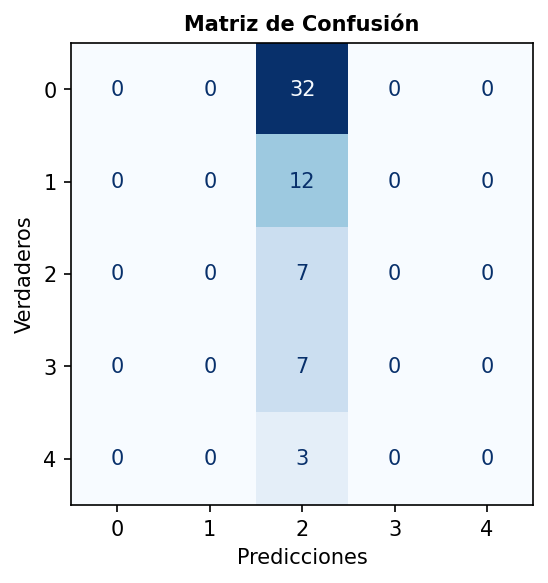

In [212]:
bn.confusion_matrix()

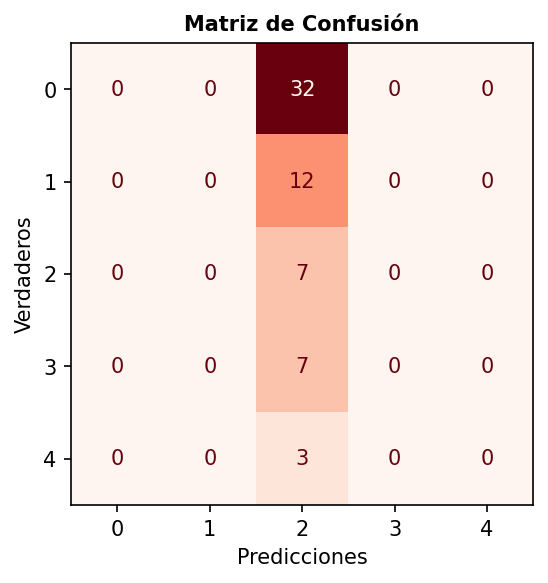

In [213]:
bn.confusion_matrix(cmap='Reds')

In [214]:
bn.reporte_de_clasificacion()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        12
           2       0.11      1.00      0.21         7
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3

    accuracy                           0.11        61
   macro avg       0.02      0.20      0.04        61
weighted avg       0.01      0.11      0.02        61



c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo